In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train_full = pd.read_csv("train.csv")

# Hydrology Engineering

In [3]:
train_full.loc[:, 'Euclidian_Distance'] = np.sqrt((train_full['Vertical_Distance_To_Hydrology'] ** 2) + (train_full['Horizontal_Distance_To_Hydrology'] ** 2))
train_full.loc[:, 'Hydrology_Ratio'] = train_full['Vertical_Distance_To_Hydrology'] / train_full['Horizontal_Distance_To_Hydrology']
train_full.loc[:, 'Hydrology_Ratio'].fillna(0, inplace=True)
#"Horizontal_Distance_To_Hydrology" and "Vertical_Distance_To_Hydrology" are highly correlated --> Euclidean distance to hydrology.


# Hillshade Enginnering

In [4]:

# Calculate mean Hillshade
def calculate_mean_hillshade(df):
    df['Mean_Hillshade'] = df[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']].mean(axis=1)
    return df

# Calculate median Hillshade
def calculate_median_hillshade(df):
    df['Median_Hillshade'] = df[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']].median(axis=1)
    return df

# Calculate standard deviation of Hillshade
def calculate_std_hillshade(df):
    df['Std_Hillshade'] = df[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']].std(axis=1)
    return df

# Calculate range of Hillshade
def calculate_range_hillshade(df):
    df['Range_Hillshade'] = df[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']].max(axis=1) - df[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']].min(axis=1)
    return df

# Calculate differences between Hillshade indices
def calculate_hillshade_differences(df):
    df['Diff_9am_Noon'] = df['Hillshade_9am'] - df['Hillshade_Noon']
    df['Diff_Noon_3pm'] = df['Hillshade_Noon'] - df['Hillshade_3pm']
    df['Diff_9am_3pm'] = df['Hillshade_9am'] - df['Hillshade_3pm']
    return df


def categorize_aspect(aspect):
    if 0 <= aspect <= 180:
        return 1
    elif 180 < aspect <= 360:
        return -1


#Bin Aspect 0-180, 180-360
def Bin_Aspect(df):
    df['Binned_Aspect']=df['Aspect'].apply(categorize_aspect)
    return df

#Calculate Slope times aspect binned1 or -1 for each direction in respect to sunset and sunrising
def Calculate_Slope_Aspect(df):
    df['Slope_Aspect'] = df['Slope'] * df['Binned_Aspect']
    return df

def Calculate_Hillshade_Slope_Aspect(df):
    df['Hillshade_3_9_Slope_Aspect'] = df['Hillshade_3pm']*df['Slope_Aspect']+df['Hillshade_9am']*df['Slope_Aspect']
    df['Hillshade_Noon_Slope_Aspect']= df['Hillshade_Noon']*df['Slope_Aspect']
    return df

def Calculate_Hillshade_Slope(df):
    df['Hillshade_3_9_Slope'] = df['Hillshade_3pm']*df['Slope']+df['Hillshade_9am']*df['Slope']
    df['Hillshade_Noon_Slope']= df['Hillshade_Noon']*df['Slope']
    return df




train_full = calculate_mean_hillshade(train_full)
train_full = calculate_median_hillshade(train_full)
train_full = calculate_std_hillshade(train_full)
train_full = calculate_range_hillshade(train_full)
train_full = calculate_hillshade_differences(train_full)
train_full = Bin_Aspect(train_full)
train_full = Calculate_Slope_Aspect(train_full)
train_full = Calculate_Hillshade_Slope_Aspect(train_full)
train_full =Calculate_Hillshade_Slope(train_full)



# Soiltype Engineering

In [5]:
"""
First digit: climatic zone

1: lower montane dry: -
2: lower montane: 1-6
3: montane dry: 7, 8
4: montane: 9-13
5: montane dry and montane: 14, 15 # Should we add these two two the two previous ones each ?
6: montane and subalpine: 16-18
7: subalpine: 19-34
8: alpine: 35-40
Second digit: geologic zones

1: alluvium: 14-17, 19-21
2: glacial: 9, 22, 23
3: shale: -
4: sandstone: -
5: mixed sedimentary: 7, 8
6: unspecified in the USFS ELU Survey: -
7: igneous and metamorphic: 1-6, 10-13, 18, 24-40
8: volcanic: -


The third and fourth ELU digits are unique to the mapping unit and have no special meaning to the climatic or geologic zones.

"""

'\nFirst digit: climatic zone\n\n1: lower montane dry: -\n2: lower montane: 1-6\n3: montane dry: 7, 8\n4: montane: 9-13\n5: montane dry and montane: 14, 15 # Should we add these two two the two previous ones each ?\n6: montane and subalpine: 16-18\n7: subalpine: 19-34\n8: alpine: 35-40\nSecond digit: geologic zones\n\n1: alluvium: 14-17, 19-21\n2: glacial: 9, 22, 23\n3: shale: -\n4: sandstone: -\n5: mixed sedimentary: 7, 8\n6: unspecified in the USFS ELU Survey: -\n7: igneous and metamorphic: 1-6, 10-13, 18, 24-40\n8: volcanic: -\n\n\nThe third and fourth ELU digits are unique to the mapping unit and have no special meaning to the climatic or geologic zones.\n\n'

In [6]:
# First digit: climatic zone
train_full.loc[:, 'lower_montane'] = train_full.loc[:, [col for col in train_full if col.endswith(tuple(f'Type{i}' for i in range (1, 7)))]].sum(axis=1)
train_full.loc[:, 'montane_dry'] = train_full.loc[:, [col for col in train_full if col.endswith(('Type7', 'Type8'))]].sum(axis=1)
train_full.loc[:, 'montane'] = train_full.loc[:, [col for col in train_full if col.endswith(tuple(f'Type{i}' for i in range (9, 14)))]].sum(axis=1)
train_full.loc[:, 'montane_dry_and_montane'] = train_full.loc[:, [col for col in train_full if col.endswith(('Type14', 'Type15'))]].sum(axis=1)
train_full.loc[:, 'montane_and_subalpine'] = train_full.loc[:, [col for col in train_full if col.endswith(('Type16', 'Type17', 'Type18'))]].sum(axis=1)
train_full.loc[:, 'subalpine'] = train_full.loc[:, [col for col in train_full if col.endswith(tuple(f'Type{i}' for i in range (19, 35)))]].sum(axis=1)
train_full.loc[:, 'alpine'] = train_full.loc[:, [col for col in train_full if col.endswith(tuple(f'Type{i}' for i in range (35, 41)))]].sum(axis=1)


In [7]:
# Second digit: geologic zones

train_full.loc[:, 'alluvium'] = train_full.loc[:, [col for col in train_full if col.endswith(tuple(f'Type{i}' for i in range (14, 8)) + tuple(f'Type{i}' for i in range (19, 21)))]].sum(axis=1)
train_full.loc[:, 'glacial'] = train_full.loc[:, [col for col in train_full if col.endswith(('Type9', 'Type22', 'Type23'))]].sum(axis=1)
train_full.loc[:, 'mixed_sedimentary'] = train_full.loc[:, [col for col in train_full if col.endswith(('Type7', 'Type8'))]].sum(axis=1)
train_full.loc[:, 'igneous_and_metamorphic'] = train_full.loc[:, [col for col in train_full if col.endswith(tuple(f'Type{i}' for i in range (1, 7)) + tuple(f'Type{i}' for i in range (10, 14)) + tuple(['Type18']) + tuple(f'Type{i}' for i in range (24, 41)))]].sum(axis=1)


In [8]:
#One vector for all Soiltype
Soiltype_list=[]

for i in range(1,41):
    Soiltype_list.append('Soil_Type'+str(i))

train_full['Soil_type'] = train_full[Soiltype_list].apply(lambda x: (list(x).index(1)+1), axis=1)

In [9]:
for soil_t in Soiltype_list:
  train_full.drop(soil_t,axis=1,inplace=True)



In [10]:
train_full.columns

Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Cover_Type', 'Euclidian_Distance',
       'Hydrology_Ratio', 'Mean_Hillshade', 'Median_Hillshade',
       'Std_Hillshade', 'Range_Hillshade', 'Diff_9am_Noon', 'Diff_Noon_3pm',
       'Diff_9am_3pm', 'Binned_Aspect', 'Slope_Aspect',
       'Hillshade_3_9_Slope_Aspect', 'Hillshade_Noon_Slope_Aspect',
       'Hillshade_3_9_Slope', 'Hillshade_Noon_Slope', 'lower_montane',
       'montane_dry', 'montane', 'montane_dry_and_montane',
       'montane_and_subalpine', 'subalpine', 'alpine', 'alluvium', 'glacial',
       'mixed_sedimentary', 'igneous_and_metamorphic', 'Soil_type'],
      dtype='object')




# SVM


# Feature Importance


C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


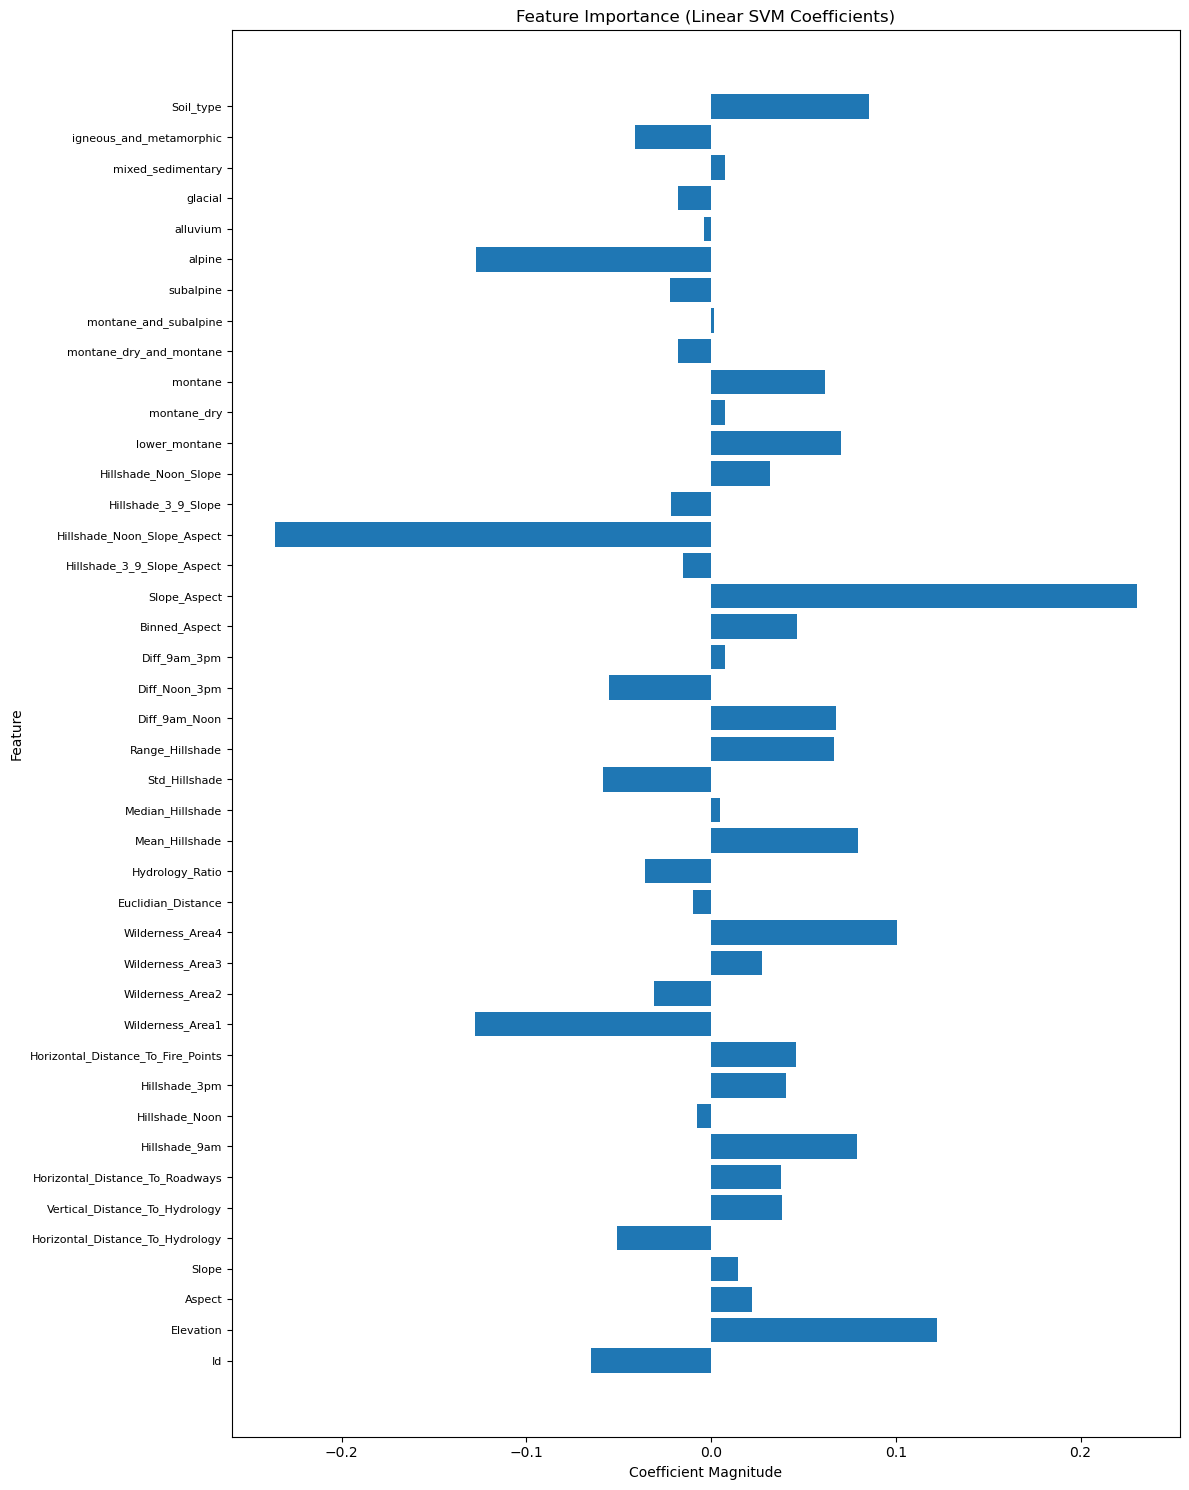

In [11]:
from sklearn import datasets
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC,LinearSVC
from sklearn.feature_selection import RFECV,RFE
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.multiclass import OneVsRestClassifier
from sklearn.datasets import make_classification




X=train_full.drop(['Cover_Type'],axis=1)
Y=train_full['Cover_Type']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
svm_model = LinearSVC()

X_train, X_test, y_train, y_test = train_test_split(X_scaled,Y, train_size=0.80, random_state=42)

# Train the model
svm_model.fit(X_train, y_train)



#I need  to do the average
coefs = svm_model.coef_ 
avg_coefs = [sum(x) / len(x) for x in zip(*svm_model.coef_)]  

# Visualize the feature importances using coefficients
plt.figure(figsize=(12, 15))  # Increase the figure size (width, height) as needed
plt.barh(range(X_train.shape[1]), avg_coefs, align='center')
plt.yticks(range(X_train.shape[1]), X.columns, fontsize=8)  # You can adjust the fontsize as needed
plt.xlabel("Coefficient Magnitude", fontsize=10)  # Adjust fontsize for x-axis label
plt.ylabel("Feature", fontsize=10)  # Adjust fontsize for y-axis label
plt.title("Feature Importance (Linear SVM Coefficients)", fontsize=12)  # Adjust fontsize for title
plt.tight_layout()  # This will adjust spacing to fit everything nicely
plt.savefig('feature_importance_linear_svm.eps')
plt.show()

# Permutation Importance

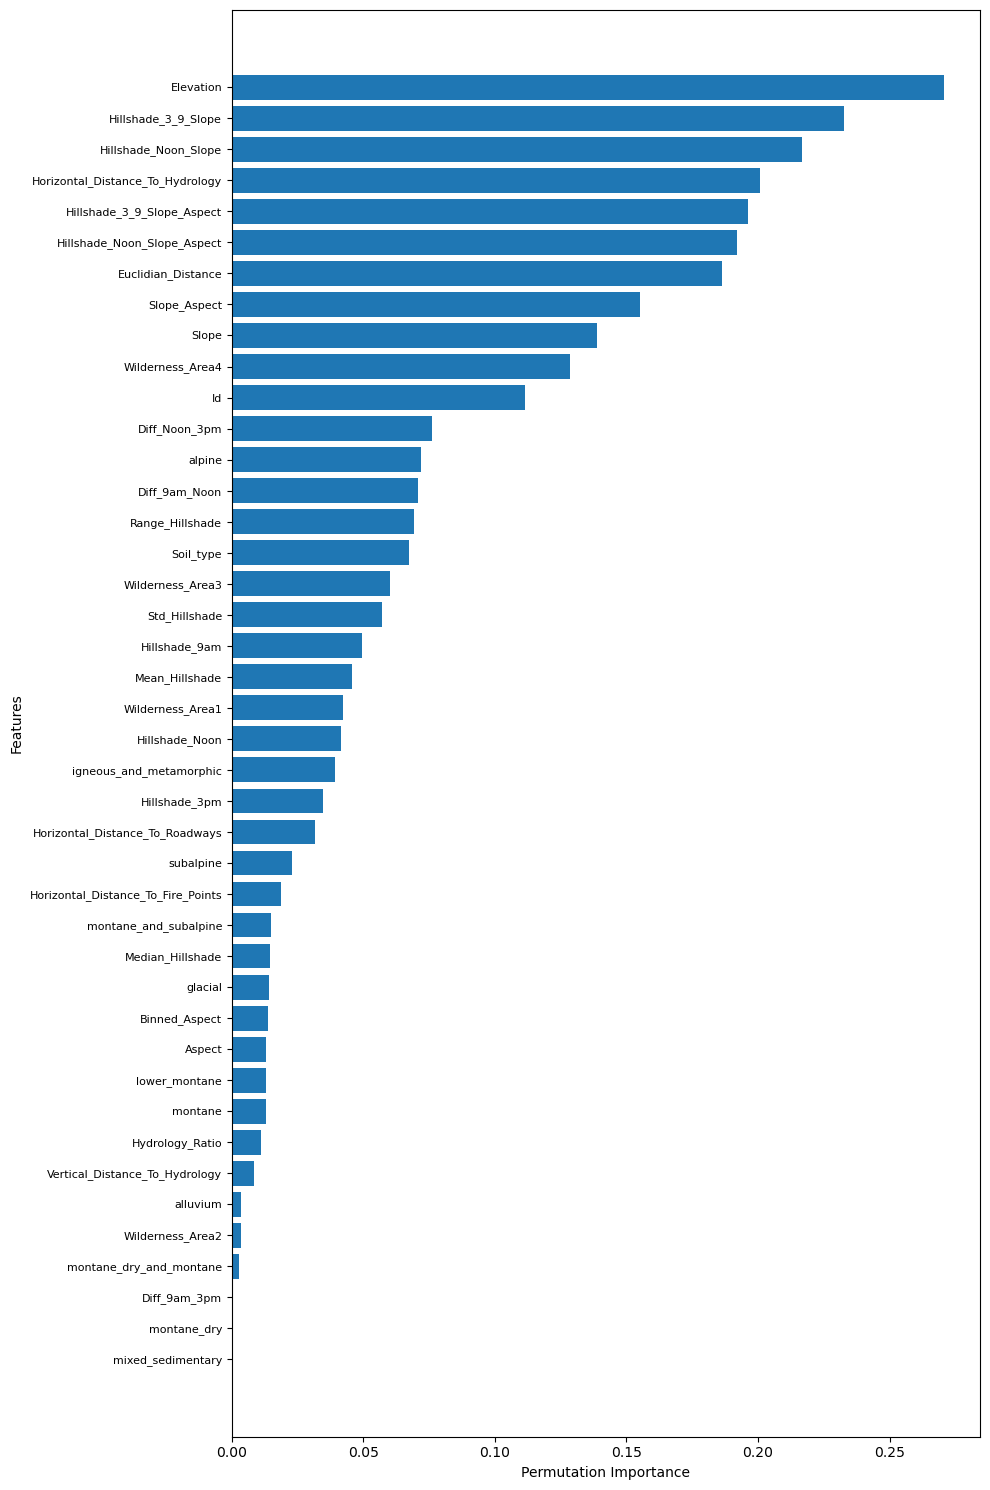

In [4]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance
perm_importance = permutation_importance(svm_model, X_test, y_test, n_repeats=30, random_state=42)

# Get sorted importances
sorted_idx = perm_importance.importances_mean.argsort()

# Visualize the feature importances
plt.figure(figsize=(10, 15))  # Increase the figure height from the current value to 15
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.ylabel("Features")
plt.yticks(fontsize=8)  # Decrease font size if necessary
plt.tight_layout() 
plt.savefig('permutation_importance_linear_svm.eps')# Adjust layout to prevent clipping of ytick labels
plt.show()



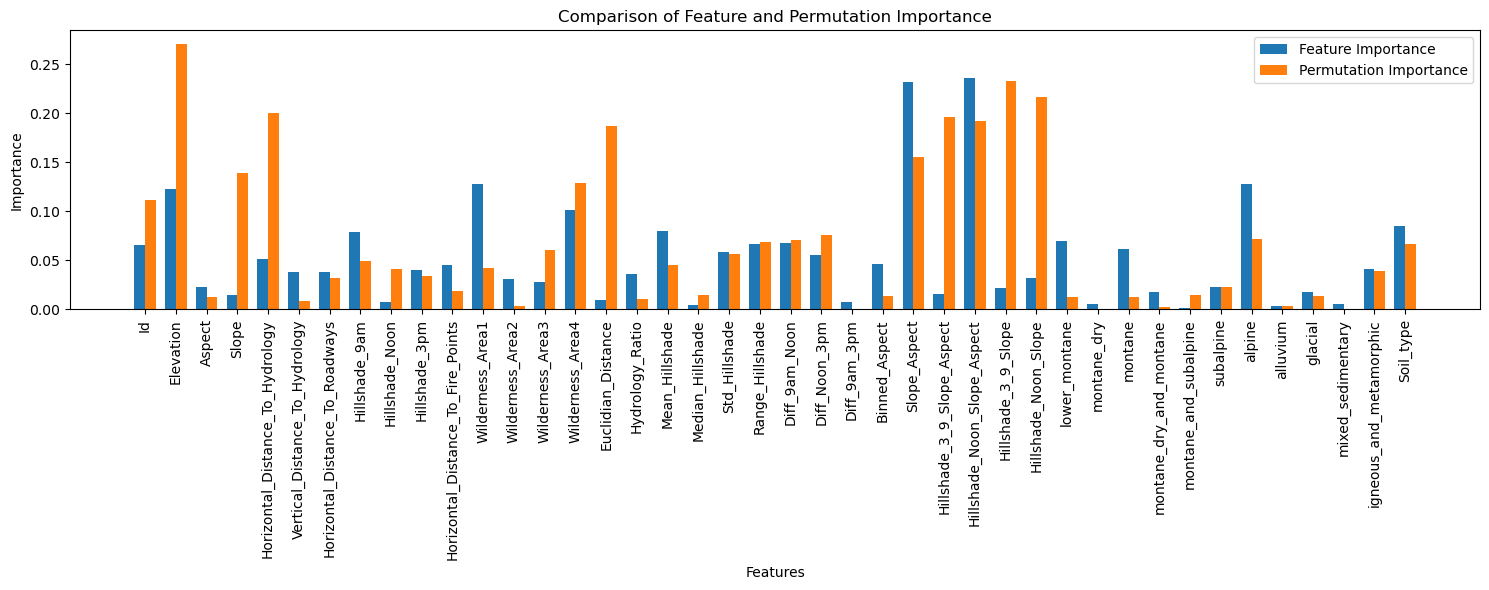

In [5]:
pos = np.arange(len(X.columns))
bar_width = 0.35

fig, ax = plt.subplots(figsize=(15, 6))
bar1 = ax.bar(pos - bar_width/2, [abs(a) for a in avg_coefs], bar_width, label='Feature Importance')
bar2 = ax.bar(pos + bar_width/2, perm_importance.importances_mean, bar_width, label='Permutation Importance')



ax.set_xlabel('Features')
ax.set_ylabel('Importance')
ax.set_title('Comparison of Feature and Permutation Importance')
ax.set_xticks(pos)
ax.set_xticklabels(X.columns)
ax.legend()

# Plotting feature importance and feature importance 
plt.xticks(rotation=90)  # Rotate feature names for better readability
plt.tight_layout()  # Adjust layout
plt.savefig('permutation_vs_Feature.png')
plt.show()

# Lasso

In [12]:
svc = LinearSVC(penalty='l1', dual=False, loss='squared_hinge', max_iter=10000, C=1, random_state=42)

svc.fit(X_train, y_train)
# Check the coefficients returned for each feature
print("Coefficients per class:")
print(svc.coef_)



Coefficients per class:
[[ 2.46340748e-01  5.79709029e-01 -7.15167053e-02 -4.24239681e-01
   1.40686342e+00  4.90720831e-03  2.35013329e-02 -9.37313694e-02
  -2.69612794e-01  0.00000000e+00 -2.70251706e-02  1.59831085e-01
   0.00000000e+00 -5.17097098e-02  0.00000000e+00 -1.43366529e+00
  -2.24791817e-02  0.00000000e+00  6.02854734e-02  3.09601504e-01
  -2.85654902e-01  0.00000000e+00 -6.73532817e-02  0.00000000e+00
  -1.03540261e-01 -8.61502561e-02  9.70067669e-03  5.33400853e-02
  -2.52790273e-01  5.68290352e-01  0.00000000e+00  1.63034785e-03
   3.19358606e-01 -1.68065788e-02 -5.82846134e-02  4.76470124e-01
   0.00000000e+00 -6.18847547e-02 -1.86211315e-01  9.23875202e-03
  -3.42148121e-01  2.50926884e-03]
 [ 3.53256927e-02 -2.46409348e-01  2.12370478e-02 -5.90112535e-01
   0.00000000e+00 -1.11068121e-02  8.97333241e-02 -1.61815647e-01
   0.00000000e+00  0.00000000e+00  9.72235278e-02  1.24971127e-01
   5.16430073e-02  0.00000000e+00 -2.24312685e-01  1.06656451e-01
   1.85459139e-02

C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [13]:
from IPython.display import display, Markdown

# Identify features that have non-zero coefficients (i.e., selected by the Lasso)
avg_coefs =  [sum(abs(_) for _ in x) / len(x) for x in zip(*svc.coef_)]
selected_features = []
for _ in avg_coefs:
    if _<10**(-1):
        selected_features.append(False)
    else:
        selected_features.append(True)


# Number of selected features
num_selected_features = sum(selected_features)

# Names of selected features
selected_feature_names = X.columns[selected_features].tolist()

# Names of unselected features
unselected_feature_names = X.columns[[not b for b in selected_features]].tolist()

# Display the summary
display(Markdown(f"**Number of Selected Features:** {num_selected_features}"))
display(Markdown(f"**Selected Features:** {', '.join(selected_feature_names)}"))
display(Markdown(f"**Unselected Features:** {', '.join(unselected_feature_names)}"))

**Number of Selected Features:** 30

**Selected Features:** Id, Elevation, Aspect, Slope, Horizontal_Distance_To_Hydrology, Horizontal_Distance_To_Roadways, Hillshade_9am, Hillshade_Noon, Horizontal_Distance_To_Fire_Points, Wilderness_Area1, Wilderness_Area4, Euclidian_Distance, Hydrology_Ratio, Mean_Hillshade, Median_Hillshade, Std_Hillshade, Range_Hillshade, Diff_9am_Noon, Diff_Noon_3pm, Binned_Aspect, Slope_Aspect, Hillshade_3_9_Slope_Aspect, Hillshade_Noon_Slope_Aspect, Hillshade_3_9_Slope, Hillshade_Noon_Slope, lower_montane, montane, alpine, igneous_and_metamorphic, Soil_type

**Unselected Features:** Vertical_Distance_To_Hydrology, Hillshade_3pm, Wilderness_Area2, Wilderness_Area3, Diff_9am_3pm, montane_dry, montane_dry_and_montane, montane_and_subalpine, subalpine, alluvium, glacial, mixed_sedimentary

# RFECV


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, train_size=0.80, random_state=42)


selector=RFECV(LinearSVC(), step=1, cv=StratifiedKFold(5),scoring='accuracy')
selector = selector.fit(X_train, y_train)

print("Selected Features):", X.columns[selector.support_])
print("Ranking of features:", selector.ranking_)


C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` expl

C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\nacer

C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\nacer

C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\nacer

C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\nacer

C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\nacer

C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\nacer

C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\nacer

C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\nacer

C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\nacer

C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Selected Features): Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Euclidian_Distance', 'Hydrology_Ratio',
       'Mean_Hillshade', 'Median_Hillshade', 'Std_Hillshade',
       'Range_Hillshade', 'Diff_9am_Noon', 'Diff_Noon_3pm', 'Binned_Aspect',
       'Slope_Aspect', 'Hillshade_3_9_Slope_Aspect',
       'Hillshade_Noon_Slope_Aspect', 'Hillshade_3_9_Slope',
       'Hillshade_Noon_Slope', 'lower_montane', 'montane',
       'montane_and_subalpine', 'subalpine', 'alpine', 'glacial',
       'igneous_and_metamorphic', 'Soil_type'],
      dtype='object')
Ranking of features: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 5 1 2 1 1 1
 3 1 6 1 1]


C:\Users\nacer\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [17]:
from IPython.display import display, Markdown

unselected_feature_names = X.columns[[not b for b in selector.support_]].tolist()

display(Markdown(f"**Number of Selected Features:** {len(selected_features)}"))
display(Markdown(f"**Selected Features:** {', '.join(X.columns[selector.support_])}"))
display(Markdown(f"**Unselected Features:** {', '.join(unselected_feature_names)}"))


**Number of Selected Features:** 42

**Selected Features:** Id, Elevation, Aspect, Slope, Horizontal_Distance_To_Hydrology, Vertical_Distance_To_Hydrology, Horizontal_Distance_To_Roadways, Hillshade_9am, Hillshade_Noon, Hillshade_3pm, Horizontal_Distance_To_Fire_Points, Wilderness_Area1, Wilderness_Area2, Wilderness_Area3, Wilderness_Area4, Euclidian_Distance, Hydrology_Ratio, Mean_Hillshade, Median_Hillshade, Std_Hillshade, Range_Hillshade, Diff_9am_Noon, Diff_Noon_3pm, Binned_Aspect, Slope_Aspect, Hillshade_3_9_Slope_Aspect, Hillshade_Noon_Slope_Aspect, Hillshade_3_9_Slope, Hillshade_Noon_Slope, lower_montane, montane, montane_and_subalpine, subalpine, alpine, glacial, igneous_and_metamorphic, Soil_type

**Unselected Features:** Diff_9am_3pm, montane_dry, montane_dry_and_montane, alluvium, mixed_sedimentary

### Fine-Tuning :

In [54]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from scipy.stats import expon, randint

X=train_full.drop(["Vertical_Distance_To_Hydrology", "Wilderness_Area2", "Diff_9am_3pm", "montane_dry", "montane_dry_and_montane", "montane_and_subalpine", "subalpine", "alluvium", "glacial", "mixed_sedimentary", "Horizontal_Distance_To_Hydrology", "Cover_Type"],axis=1)
y=train_full['Cover_Type']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Define parameter distributions
param_distributions = {
    'C': expon(scale=100),  # Exponential distribution for C
    'gamma': expon(scale=.1),  # Exponential distribution for gamma
    'kernel': ['rbf', 'poly', 'sigmoid'],  # List of options for kernel
    'degree': randint(2, 6)  # Uniform integer distribution for degree (for 'poly' kernel)
}


svm = SVC()

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(svm, param_distributions, n_iter=100, cv=5, scoring='accuracy', random_state=42, verbose=2)


random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)


best_model = random_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test Set Accuracy:", test_score)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END C=46.92680899768591, degree=2, gamma=0.02026485043181491, kernel=rbf; total time=   3.4s
[CV] END C=46.92680899768591, degree=2, gamma=0.02026485043181491, kernel=rbf; total time=   3.1s
[CV] END C=46.92680899768591, degree=2, gamma=0.02026485043181491, kernel=rbf; total time=   3.5s
[CV] END C=46.92680899768591, degree=2, gamma=0.02026485043181491, kernel=rbf; total time=   3.2s
[CV] END C=46.92680899768591, degree=2, gamma=0.02026485043181491, kernel=rbf; total time=   3.3s
[CV] END C=90.84469696321253, degree=3, gamma=0.016959629191460518, kernel=sigmoid; total time=   2.0s
[CV] END C=90.84469696321253, degree=3, gamma=0.016959629191460518, kernel=sigmoid; total time=   2.1s
[CV] END C=90.84469696321253, degree=3, gamma=0.016959629191460518, kernel=sigmoid; total time=   2.0s
[CV] END C=90.84469696321253, degree=3, gamma=0.016959629191460518, kernel=sigmoid; total time=   1.9s
[CV] END C=90.84469696321253, degre

[CV] END C=50.27751757587391, degree=5, gamma=0.0911054412383275, kernel=sigmoid; total time=   4.0s
[CV] END C=50.27751757587391, degree=5, gamma=0.0911054412383275, kernel=sigmoid; total time=   3.8s
[CV] END C=50.27751757587391, degree=5, gamma=0.0911054412383275, kernel=sigmoid; total time=   3.7s
[CV] END C=50.27751757587391, degree=5, gamma=0.0911054412383275, kernel=sigmoid; total time=   3.8s
[CV] END C=9.265545895311563, degree=4, gamma=0.07357087289475477, kernel=poly; total time=   6.8s
[CV] END C=9.265545895311563, degree=4, gamma=0.07357087289475477, kernel=poly; total time=   6.7s
[CV] END C=9.265545895311563, degree=4, gamma=0.07357087289475477, kernel=poly; total time=   5.4s
[CV] END C=9.265545895311563, degree=4, gamma=0.07357087289475477, kernel=poly; total time=   5.6s
[CV] END C=9.265545895311563, degree=4, gamma=0.07357087289475477, kernel=poly; total time=   6.0s
[CV] END C=39.35320868030868, degree=5, gamma=0.13756318488286554, kernel=sigmoid; total time=   5.0s

[CV] END C=15.004581313900358, degree=4, gamma=0.05282819748826726, kernel=sigmoid; total time=   2.9s
[CV] END C=15.004581313900358, degree=4, gamma=0.05282819748826726, kernel=sigmoid; total time=   2.9s
[CV] END C=22.697742213232473, degree=2, gamma=0.008010427855017637, kernel=sigmoid; total time=   2.5s
[CV] END C=22.697742213232473, degree=2, gamma=0.008010427855017637, kernel=sigmoid; total time=   2.4s
[CV] END C=22.697742213232473, degree=2, gamma=0.008010427855017637, kernel=sigmoid; total time=   2.7s
[CV] END C=22.697742213232473, degree=2, gamma=0.008010427855017637, kernel=sigmoid; total time=   2.1s
[CV] END C=22.697742213232473, degree=2, gamma=0.008010427855017637, kernel=sigmoid; total time=   2.3s
[CV] END C=118.67386132926785, degree=5, gamma=0.26549500858806246, kernel=rbf; total time=   7.2s
[CV] END C=118.67386132926785, degree=5, gamma=0.26549500858806246, kernel=rbf; total time=   6.9s
[CV] END C=118.67386132926785, degree=5, gamma=0.26549500858806246, kernel=r

[CV] END C=45.8522799264304, degree=5, gamma=0.40997475859929716, kernel=poly; total time=  13.5s
[CV] END C=45.8522799264304, degree=5, gamma=0.40997475859929716, kernel=poly; total time=   9.7s
[CV] END C=45.8522799264304, degree=5, gamma=0.40997475859929716, kernel=poly; total time=  13.8s
[CV] END C=45.8522799264304, degree=5, gamma=0.40997475859929716, kernel=poly; total time=  14.0s
[CV] END C=45.8522799264304, degree=5, gamma=0.40997475859929716, kernel=poly; total time=  10.9s
[CV] END C=76.73852499523488, degree=5, gamma=0.1601197582326675, kernel=rbf; total time=   5.0s
[CV] END C=76.73852499523488, degree=5, gamma=0.1601197582326675, kernel=rbf; total time=   4.8s
[CV] END C=76.73852499523488, degree=5, gamma=0.1601197582326675, kernel=rbf; total time=   4.9s
[CV] END C=76.73852499523488, degree=5, gamma=0.1601197582326675, kernel=rbf; total time=   4.8s
[CV] END C=76.73852499523488, degree=5, gamma=0.1601197582326675, kernel=rbf; total time=   4.9s
[CV] END C=38.68102936673

[CV] END C=117.73152866548126, degree=5, gamma=0.5195302870591408, kernel=rbf; total time=  10.1s
[CV] END C=117.73152866548126, degree=5, gamma=0.5195302870591408, kernel=rbf; total time=   9.9s
[CV] END C=117.73152866548126, degree=5, gamma=0.5195302870591408, kernel=rbf; total time=   9.7s
[CV] END C=1.8240718598710015, degree=3, gamma=0.03936349089180845, kernel=sigmoid; total time=   2.6s
[CV] END C=1.8240718598710015, degree=3, gamma=0.03936349089180845, kernel=sigmoid; total time=   2.4s
[CV] END C=1.8240718598710015, degree=3, gamma=0.03936349089180845, kernel=sigmoid; total time=   2.4s
[CV] END C=1.8240718598710015, degree=3, gamma=0.03936349089180845, kernel=sigmoid; total time=   2.5s
[CV] END C=1.8240718598710015, degree=3, gamma=0.03936349089180845, kernel=sigmoid; total time=   2.4s
[CV] END C=127.63281950787429, degree=5, gamma=0.08400443055872575, kernel=sigmoid; total time=   3.5s
[CV] END C=127.63281950787429, degree=5, gamma=0.08400443055872575, kernel=sigmoid; tota

[CV] END C=135.003424835367, degree=2, gamma=0.014690190249215203, kernel=poly; total time=   2.4s
[CV] END C=44.549234231494914, degree=2, gamma=0.035170182136291576, kernel=poly; total time=   2.5s
[CV] END C=44.549234231494914, degree=2, gamma=0.035170182136291576, kernel=poly; total time=   3.6s
[CV] END C=44.549234231494914, degree=2, gamma=0.035170182136291576, kernel=poly; total time=   4.4s
[CV] END C=44.549234231494914, degree=2, gamma=0.035170182136291576, kernel=poly; total time=   2.7s
[CV] END C=44.549234231494914, degree=2, gamma=0.035170182136291576, kernel=poly; total time=   2.8s
[CV] END C=166.13281990870288, degree=2, gamma=0.09454974016007588, kernel=poly; total time=  25.1s
[CV] END C=166.13281990870288, degree=2, gamma=0.09454974016007588, kernel=poly; total time=  25.8s
[CV] END C=166.13281990870288, degree=2, gamma=0.09454974016007588, kernel=poly; total time=  23.8s
[CV] END C=166.13281990870288, degree=2, gamma=0.09454974016007588, kernel=poly; total time=  25

[CV] END C=58.402775199144706, degree=5, gamma=0.07967906483133147, kernel=rbf; total time=   3.8s
[CV] END C=58.402775199144706, degree=5, gamma=0.07967906483133147, kernel=rbf; total time=   4.1s
[CV] END C=58.402775199144706, degree=5, gamma=0.07967906483133147, kernel=rbf; total time=   3.8s
[CV] END C=58.402775199144706, degree=5, gamma=0.07967906483133147, kernel=rbf; total time=   3.8s
[CV] END C=107.93903496967985, degree=2, gamma=0.10168588434762378, kernel=rbf; total time=   4.2s
[CV] END C=107.93903496967985, degree=2, gamma=0.10168588434762378, kernel=rbf; total time=   4.2s
[CV] END C=107.93903496967985, degree=2, gamma=0.10168588434762378, kernel=rbf; total time=   4.3s
[CV] END C=107.93903496967985, degree=2, gamma=0.10168588434762378, kernel=rbf; total time=   4.2s
[CV] END C=107.93903496967985, degree=2, gamma=0.10168588434762378, kernel=rbf; total time=   4.2s
Best Parameters: {'C': 119.1728976307604, 'degree': 4, 'gamma': 0.03579304600790468, 'kernel': 'rbf'}
Best Sc

# Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier
!pip install Boruta
from boruta import BorutaPy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

X=train_full.drop(['Cover_Type'],axis=1)
Y=train_full['Cover_Type']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled,Y, train_size=0.80, random_state=42)

In [18]:
from sklearn.ensemble import RandomForestClassifier
!pip install Boruta
from boruta import BorutaPy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

X=train_full.drop(['Cover_Type'],axis=1)
Y=train_full['Cover_Type']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled,Y, train_size=0.80, random_state=42)


rf = RandomForestClassifier(n_jobs=-1, max_depth=5)

np.int = np.int32
np.float = np.float64
np.bool = np.bool_

# Initialize Boruta
boruta_feature_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42)

# Fit Boruta (it accepts numpy arrays, not pandas DataFrames)
boruta_feature_selector.fit(X_train, y_train)

# get a boolean mask of the selected features
selected_features = boruta_feature_selector.support_
print(X.columns[selected_features])

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	42
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	42
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	42
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	42
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	42
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	42
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	42
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	38
Tentative: 	4
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	38
Tentative: 	2
Rejected: 	2
Iteration: 	10 / 100
Confirmed: 	38
Tentative: 	2
Rejected: 	2
Iteration: 	11 / 100
Confirmed: 	38
Tentative: 	2
Rejected: 	2
Iteration: 	12 / 100
Confirmed: 	38
Tentative: 	2
Rejected: 	2
Iteration: 	13 / 100
Confirmed: 	38
Tentative: 	2
Rejected: 	2
Iteration: 	14 / 100
Confirmed: 	38
Tentative: 	2
Rejected: 	2
Iteration: 	15 / 100
Confirmed: 	38
Tentative: 	2
Rejected: 	2
Iteration: 	16 / 100
Confirmed: 	38
Tentative: 	2
Rejected: 	2
I

In [19]:
from IPython.display import display, Markdown

unselected_feature_names = X.columns[[not b for b in boruta_feature_selector.support_]].tolist()

display(Markdown(f"**Number of Selected Features:** {len(selected_features)}"))
display(Markdown(f"**Selected Features:** {', '.join(X.columns[selector.support_])}"))
display(Markdown(f"**Unselected Features:** {', '.join(unselected_feature_names)}"))

**Number of Selected Features:** 42

**Selected Features:** Id, Elevation, Aspect, Slope, Horizontal_Distance_To_Hydrology, Vertical_Distance_To_Hydrology, Horizontal_Distance_To_Roadways, Hillshade_9am, Hillshade_Noon, Hillshade_3pm, Horizontal_Distance_To_Fire_Points, Wilderness_Area1, Wilderness_Area2, Wilderness_Area3, Wilderness_Area4, Euclidian_Distance, Hydrology_Ratio, Mean_Hillshade, Median_Hillshade, Std_Hillshade, Range_Hillshade, Diff_9am_Noon, Diff_Noon_3pm, Binned_Aspect, Slope_Aspect, Hillshade_3_9_Slope_Aspect, Hillshade_Noon_Slope_Aspect, Hillshade_3_9_Slope, Hillshade_Noon_Slope, lower_montane, montane, montane_and_subalpine, subalpine, alpine, glacial, igneous_and_metamorphic, Soil_type

**Unselected Features:** montane_dry, montane_dry_and_montane, alluvium, mixed_sedimentary

In [7]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)


selector=RFECV(rf, step=1, cv=StratifiedKFold(5),scoring='accuracy')
selector = selector.fit(X_train, y_train)

# Output the results
print("Selected Features):", X.columns[selector.support_])
print("Ranking of features:", selector.ranking_)

NameError: name 'RFECV' is not defined

In [30]:
from IPython.display import display, Markdown

unselected_feature_names = X.columns[[not b for b in selector.support_]].tolist()

display(Markdown(f"**Number of Selected Features:** {len(selected_features)}"))
display(Markdown(f"**Selected Features:** {', '.join(X.columns[selector.support_])}"))
display(Markdown(f"**Unselected Features:** {', '.join(unselected_feature_names)}"))

**Number of Selected Features:** 7

**Selected Features:** Id, Elevation, Horizontal_Distance_To_Roadways, Hillshade_Noon, Horizontal_Distance_To_Fire_Points, Euclidian_Distance, Diff_Noon_3pm, Soil_type

**Unselected Features:** Aspect, Slope, Horizontal_Distance_To_Hydrology, Vertical_Distance_To_Hydrology, Hillshade_9am, Hillshade_3pm, Wilderness_Area1, Wilderness_Area2, Wilderness_Area3, Wilderness_Area4, Hydrology_Ratio, Mean_Hillshade, Median_Hillshade, Std_Hillshade, Range_Hillshade, Diff_9am_Noon, Diff_9am_3pm, Binned_Aspect, Slope_Aspect, Hillshade_3_9_Slope_Aspect, Hillshade_Noon_Slope_Aspect, Hillshade_3_9_Slope, Hillshade_Noon_Slope, lower_montane, montane_dry, montane, montane_dry_and_montane, montane_and_subalpine, subalpine, alpine, alluvium, glacial, mixed_sedimentary, igneous_and_metamorphic

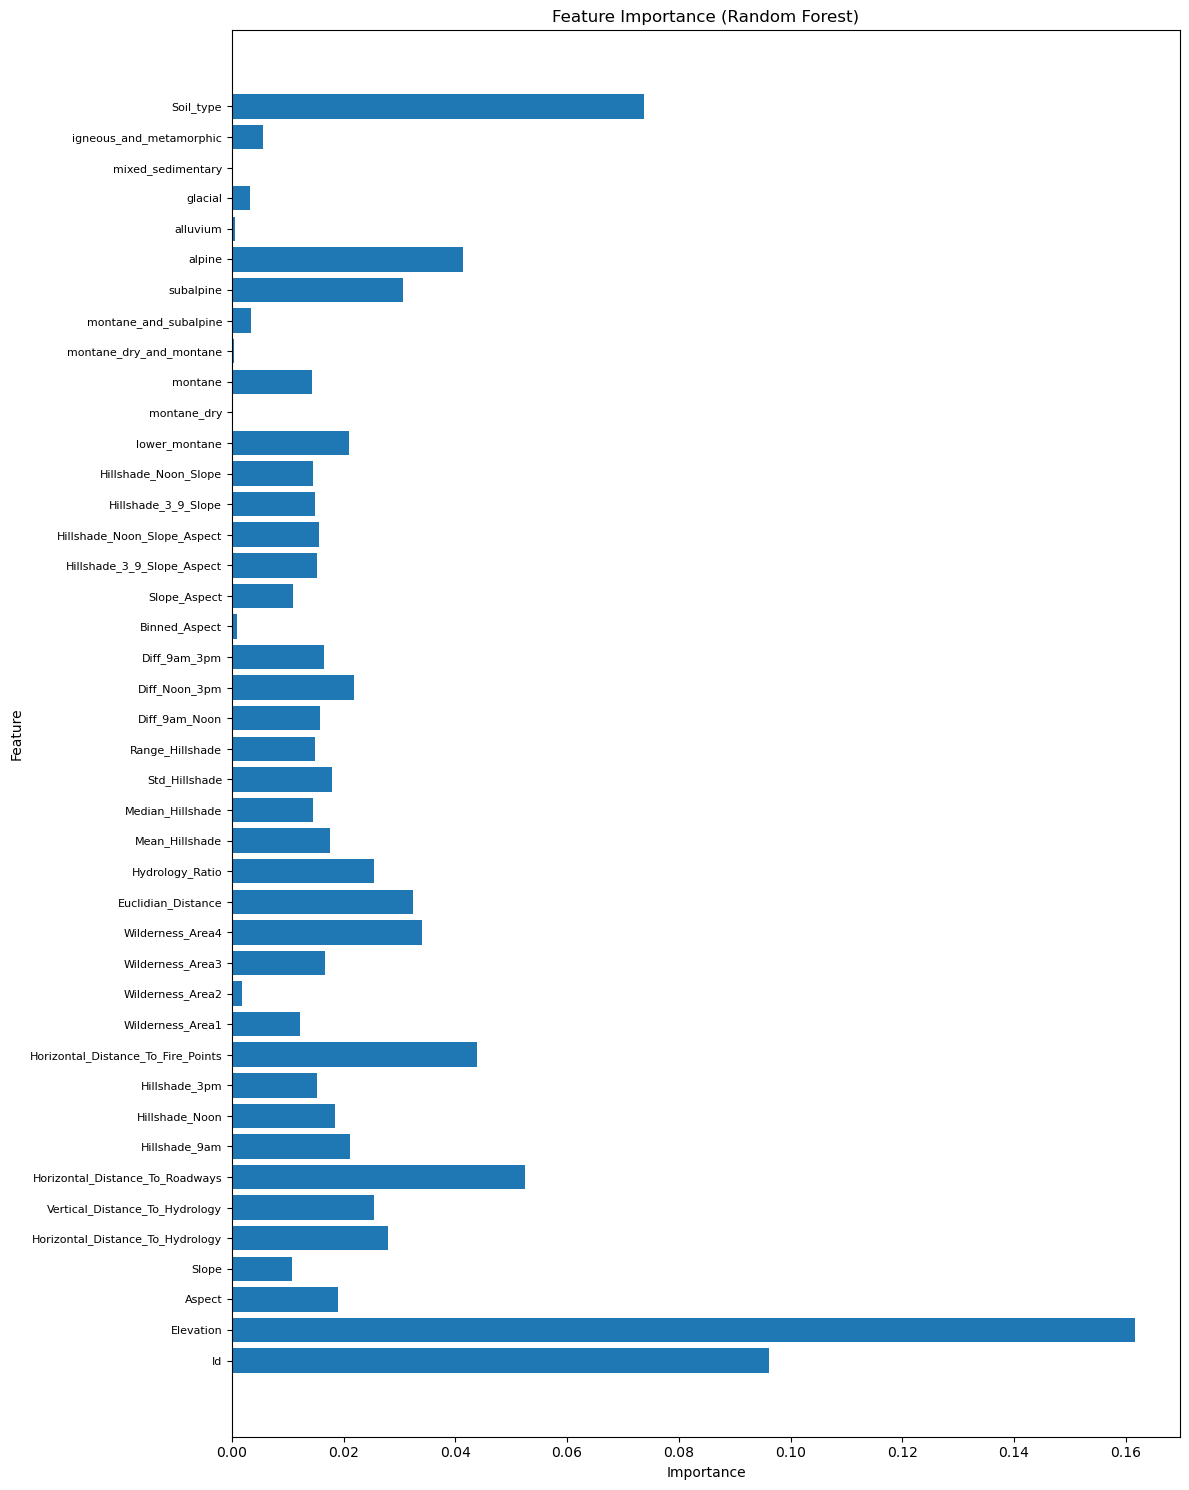

In [11]:
random_forest_model = RandomForestClassifier(random_state=42)
random_forest_model.fit(X_train, y_train)

# Get feature importances
feature_importances = random_forest_model.feature_importances_

plt.figure(figsize=(12, 15))  
plt.barh(range(X_train.shape[1]), feature_importances, align='center')
plt.yticks(range(X_train.shape[1]), X.columns, fontsize=8)  
plt.xlabel("Importance", fontsize=10)  
plt.ylabel("Feature", fontsize=10)  
plt.title("Feature Importance (Random Forest)", fontsize=12)  
plt.tight_layout() 
plt.show()

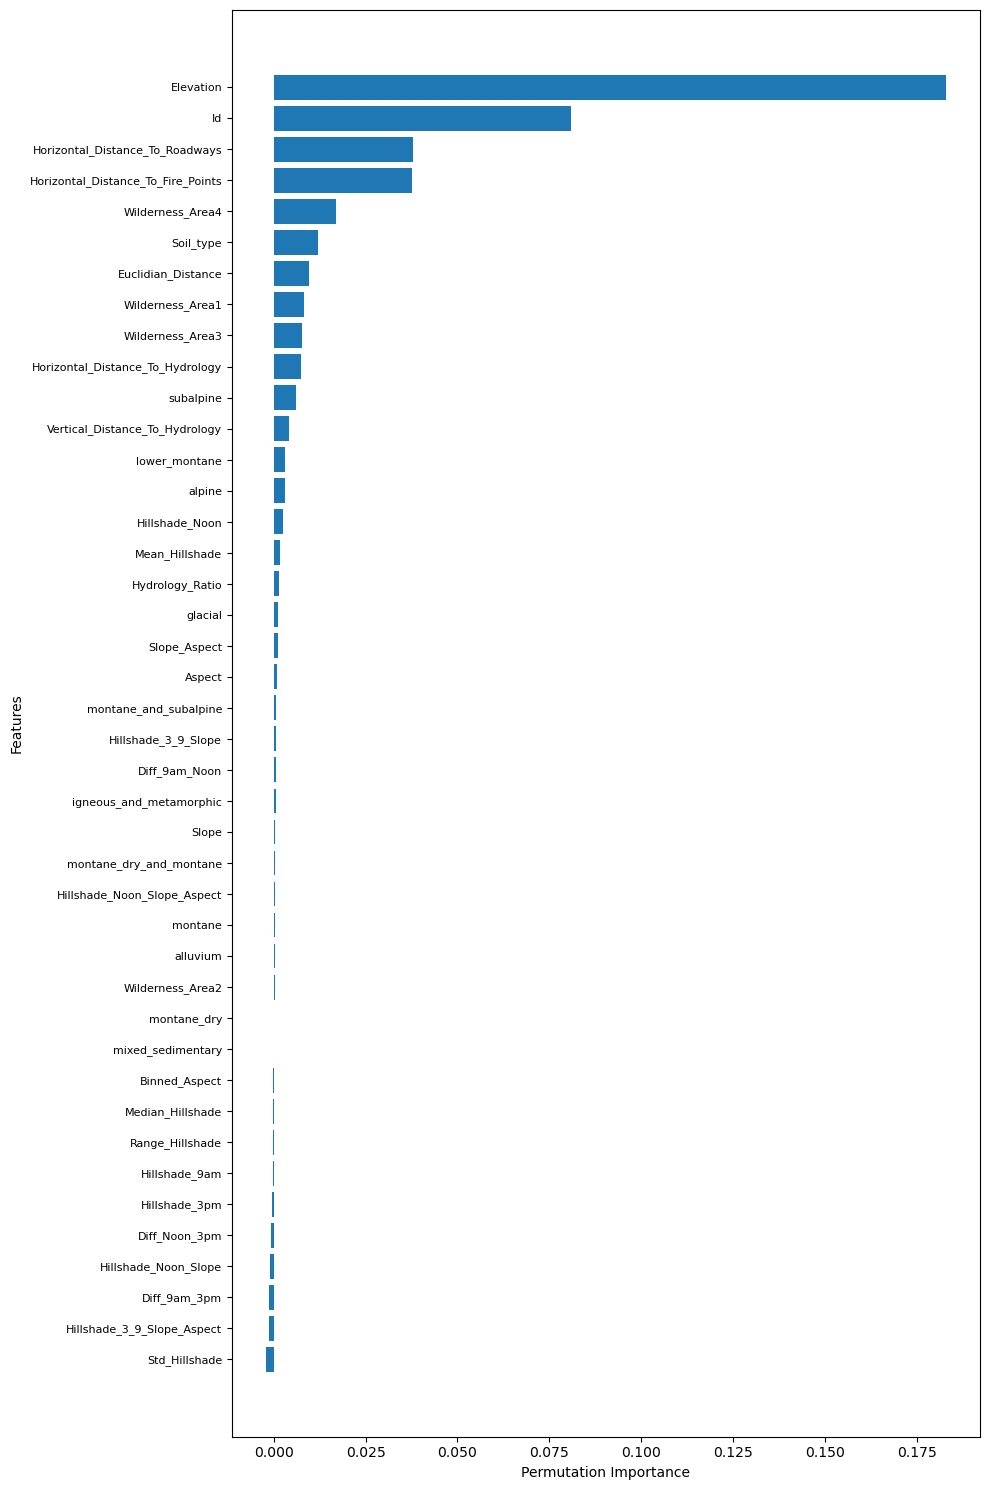

In [28]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance
perm_importance = permutation_importance(random_forest_model, X_test, y_test, n_repeats=30, random_state=42)

# Get sorted importances
sorted_idx = perm_importance.importances_mean.argsort()

# Visualize the feature importances
plt.figure(figsize=(10, 15)) 
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.ylabel("Features")
plt.yticks(fontsize=8)  
plt.tight_layout()  
plt.show()

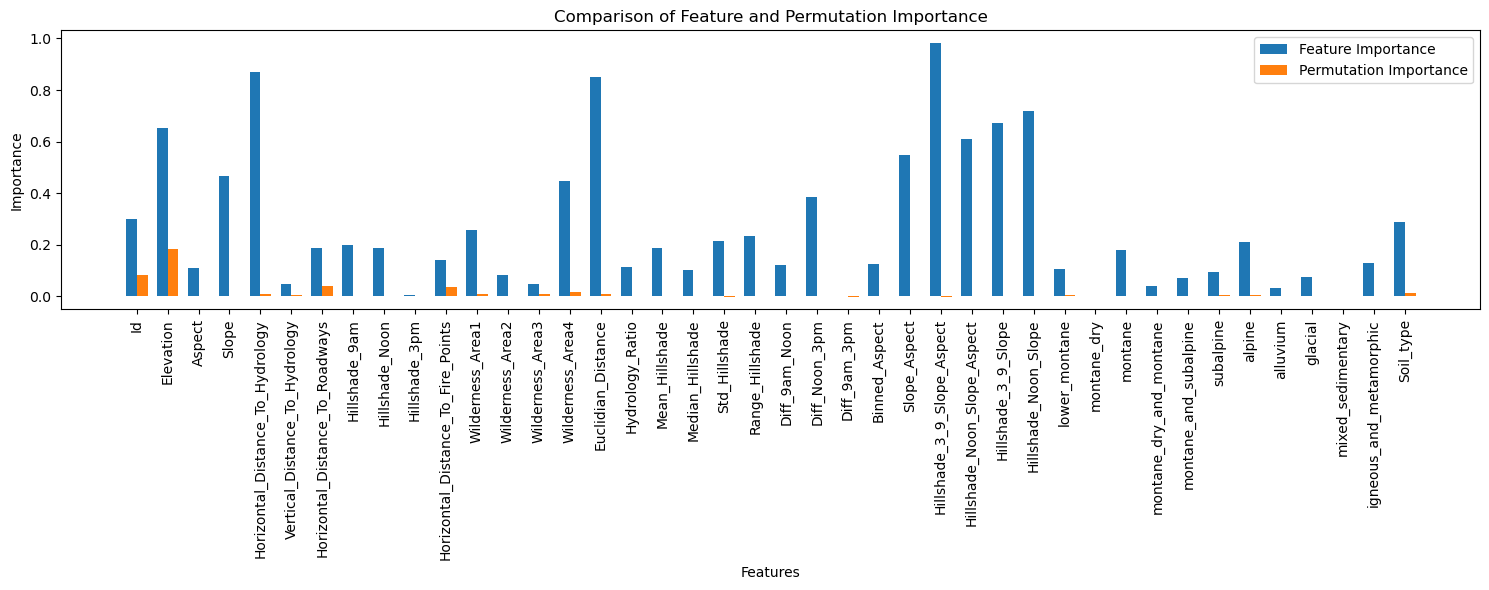

In [29]:
pos = np.arange(len(X.columns))
bar_width = 0.35

fig, ax = plt.subplots(figsize=(15, 6))
bar1 = ax.bar(pos - bar_width/2, [abs(a) for a in avg_coefs], bar_width, label='Feature Importance')
bar2 = ax.bar(pos + bar_width/2, perm_importance.importances_mean, bar_width, label='Permutation Importance')




ax.set_xlabel('Features')
ax.set_ylabel('Importance')
ax.set_title('Comparison of Feature and Permutation Importance')
ax.set_xticks(pos)
ax.set_xticklabels(X.columns)
ax.legend()

# Show the plot
plt.xticks(rotation=90)  # Rotate feature names for better readability
plt.tight_layout()  
plt.savefig('permutation_vs_Feature.jpg')
plt.show()

# Fine-Tuning

In [32]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from scipy.stats import randint, uniform


#After featue selection
X=train_full.drop(["Vertical_Distance_To_Hydrology", "Wilderness_Area2", "Diff_9am_3pm", "montane_dry", "montane_dry_and_montane", "montane_and_subalpine", "subalpine", "alluvium", "glacial", "mixed_sedimentary", "Horizontal_Distance_To_Hydrology", "Cover_Type"],axis=1)
y=train_full['Cover_Type']



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define parameter distributions
param_distributions = {
    'n_estimators': randint(100, 1000),  # Uniform distribution over [100, 1000) for n_estimators
    'max_features': ['auto', 'sqrt'],  # List of options for max_features
    'max_depth': randint(10, 100),  # Uniform distribution for max_depth
    'min_samples_split': randint(2, 10),  # Uniform distribution for min_samples_split
    'min_samples_leaf': randint(1, 5),  # Uniform distribution for min_samples_leaf
    'bootstrap': [True, False]  # List of options for bootstrap
}


rf = RandomForestClassifier()

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(rf, param_distributions, n_iter=100, cv=5, scoring='accuracy', random_state=42, verbose=2)


random_search.fit(X_train, y_train)


print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)


best_model = random_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test Set Accuracy:", test_score)


KeyError: "['Cover_Type'] not found in axis"

# Testing

In [36]:
#training the model with the new parameter
X=train_full.drop(["Vertical_Distance_To_Hydrology", "Wilderness_Area2", "Diff_9am_3pm", "montane_dry", "montane_dry_and_montane", "montane_and_subalpine", "subalpine", "alluvium", "glacial", "mixed_sedimentary", "Horizontal_Distance_To_Hydrology", "Cover_Type"],axis=1)
y=train_full['Cover_Type']


# Assuming feature selection is done, X is now your feature-selected dataset
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Initialize a Random Forest model
rf = RandomForestClassifier(bootstrap=False, max_depth= 71, max_features= 'sqrt', min_samples_leaf= 1, min_samples_split= 9, n_estimators= 848)

rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=71, min_samples_split=9,
                       n_estimators=848)

In [38]:
#importing the test file
train_full = pd.read_csv("test-full.csv")
train_full.loc[:, 'Euclidian_Distance'] = np.sqrt((train_full['Vertical_Distance_To_Hydrology'] ** 2) + (train_full['Horizontal_Distance_To_Hydrology'] ** 2))
train_full.loc[:, 'Hydrology_Ratio'] = train_full['Vertical_Distance_To_Hydrology'] / train_full['Horizontal_Distance_To_Hydrology']
train_full.loc[:, 'Hydrology_Ratio'].fillna(0, inplace=True)


# Calculate mean Hillshade
def calculate_mean_hillshade(df):
    df['Mean_Hillshade'] = df[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']].mean(axis=1)
    return df

# Calculate median Hillshade
def calculate_median_hillshade(df):
    df['Median_Hillshade'] = df[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']].median(axis=1)
    return df

# Calculate standard deviation of Hillshade
def calculate_std_hillshade(df):
    df['Std_Hillshade'] = df[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']].std(axis=1)
    return df

# Calculate range of Hillshade
def calculate_range_hillshade(df):
    df['Range_Hillshade'] = df[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']].max(axis=1) - df[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']].min(axis=1)
    return df

# Calculate differences between Hillshade indices
def calculate_hillshade_differences(df):
    df['Diff_9am_Noon'] = df['Hillshade_9am'] - df['Hillshade_Noon']
    df['Diff_Noon_3pm'] = df['Hillshade_Noon'] - df['Hillshade_3pm']
    df['Diff_9am_3pm'] = df['Hillshade_9am'] - df['Hillshade_3pm']
    return df


def categorize_aspect(aspect):
    if 0 <= aspect <= 180:
        return 1
    elif 180 < aspect <= 360:
        return -1


#Bin Aspect 0-180, 180-360
def Bin_Aspect(df):
    df['Binned_Aspect']=df['Aspect'].apply(categorize_aspect)
    return df

#Calculate Slope times aspect binned1 or -1 for each direction in respect to sunset and sunrising
def Calculate_Slope_Aspect(df):
    df['Slope_Aspect'] = df['Slope'] * df['Binned_Aspect']
    return df

def Calculate_Hillshade_Slope_Aspect(df):
    df['Hillshade_3_9_Slope_Aspect'] = df['Hillshade_3pm']*df['Slope_Aspect']+df['Hillshade_9am']*df['Slope_Aspect']
    df['Hillshade_Noon_Slope_Aspect']= df['Hillshade_Noon']*df['Slope_Aspect']
    return df

def Calculate_Hillshade_Slope(df):
    df['Hillshade_3_9_Slope'] = df['Hillshade_3pm']*df['Slope']+df['Hillshade_9am']*df['Slope']
    df['Hillshade_Noon_Slope']= df['Hillshade_Noon']*df['Slope']
    return df




train_full = calculate_mean_hillshade(train_full)
train_full = calculate_median_hillshade(train_full)
train_full = calculate_std_hillshade(train_full)
train_full = calculate_range_hillshade(train_full)
train_full = calculate_hillshade_differences(train_full)
train_full = Bin_Aspect(train_full)
train_full = Calculate_Slope_Aspect(train_full)
train_full = Calculate_Hillshade_Slope_Aspect(train_full)
train_full =Calculate_Hillshade_Slope(train_full)

train_full.loc[:, 'lower_montane'] = train_full.loc[:, [col for col in train_full if col.endswith(tuple(f'Type{i}' for i in range (1, 7)))]].sum(axis=1)
train_full.loc[:, 'montane_dry'] = train_full.loc[:, [col for col in train_full if col.endswith(('Type7', 'Type8'))]].sum(axis=1)
train_full.loc[:, 'montane'] = train_full.loc[:, [col for col in train_full if col.endswith(tuple(f'Type{i}' for i in range (9, 14)))]].sum(axis=1)
train_full.loc[:, 'montane_dry_and_montane'] = train_full.loc[:, [col for col in train_full if col.endswith(('Type14', 'Type15'))]].sum(axis=1)
train_full.loc[:, 'montane_and_subalpine'] = train_full.loc[:, [col for col in train_full if col.endswith(('Type16', 'Type17', 'Type18'))]].sum(axis=1)
train_full.loc[:, 'subalpine'] = train_full.loc[:, [col for col in train_full if col.endswith(tuple(f'Type{i}' for i in range (19, 35)))]].sum(axis=1)
train_full.loc[:, 'alpine'] = train_full.loc[:, [col for col in train_full if col.endswith(tuple(f'Type{i}' for i in range (35, 41)))]].sum(axis=1)

train_full.loc[:, 'alluvium'] = train_full.loc[:, [col for col in train_full if col.endswith(tuple(f'Type{i}' for i in range (14, 8)) + tuple(f'Type{i}' for i in range (19, 21)))]].sum(axis=1)
train_full.loc[:, 'glacial'] = train_full.loc[:, [col for col in train_full if col.endswith(('Type9', 'Type22', 'Type23'))]].sum(axis=1)
train_full.loc[:, 'mixed_sedimentary'] = train_full.loc[:, [col for col in train_full if col.endswith(('Type7', 'Type8'))]].sum(axis=1)
train_full.loc[:, 'igneous_and_metamorphic'] = train_full.loc[:, [col for col in train_full if col.endswith(tuple(f'Type{i}' for i in range (1, 7)) + tuple(f'Type{i}' for i in range (10, 14)) + tuple(['Type18']) + tuple(f'Type{i}' for i in range (24, 41)))]].sum(axis=1)

#One vector for all Soiltype
Soiltype_list=[]

for i in range(1,41):
    Soiltype_list.append('Soil_Type'+str(i))

train_full['Soil_type'] = train_full[Soiltype_list].apply(lambda x: (list(x).index(1)+1), axis=1)

for soil_t in Soiltype_list:
  train_full.drop(soil_t,axis=1,inplace=True)

X=train_full.drop(["Vertical_Distance_To_Hydrology", "Wilderness_Area2", "Diff_9am_3pm", "montane_dry", "montane_dry_and_montane", "montane_and_subalpine", "subalpine", "alluvium", "glacial", "mixed_sedimentary", "Horizontal_Distance_To_Hydrology"],axis=1)



y=rf.predict(X)
y

array([5, 5, 2, ..., 3, 3, 3], dtype=int64)

In [41]:
results = pd.DataFrame({"Cover_Type":y}, index=range(1, len(y) + 1))
results.index.name = "Id"
results.to_csv("1stsub.csv")